In [1]:
#Mount google drive to import dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.2 MB/s eta 0:00:00


In [3]:
#Verify that that YOLO model was imported successfully
from ultralytics import YOLO

print("Ultralytics imported OK")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics imported OK


In [4]:
#Set up a pointer to the path of the dataset (data.yaml)
#(data.yaml tells YOLO where train/val images and labels are and what the class names are (e.g., resistor, capacitor, etc.)
DATA_YAML = r"/content/drive/MyDrive/Circuit-Diagram-CNN/Circuit Component Detection/data.yaml"
print(DATA_YAML)

/content/drive/MyDrive/Circuit-Diagram-CNN/Circuit Component Detection/data.yaml


In [5]:
#We can open the file to see its contents
with open(DATA_YAML, "r") as f:
    print(f.read())

#The yaml file is essentially the dataset config file. It tells the model where the images are,
#which splits are the train/validation/test, and what the classes are and how they are indexed.

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 6
names: ['Capacitor', 'GND', 'I_dc', 'Inductor', 'Resistor', 'V_dc']

roboflow:
  workspace: iut-uf4xg
  project: circuit-component-detection-9wiz7
  version: 4
  license: CC BY 4.0
  url: https://universe.roboflow.com/iut-uf4xg/circuit-component-detection-9wiz7/dataset/4


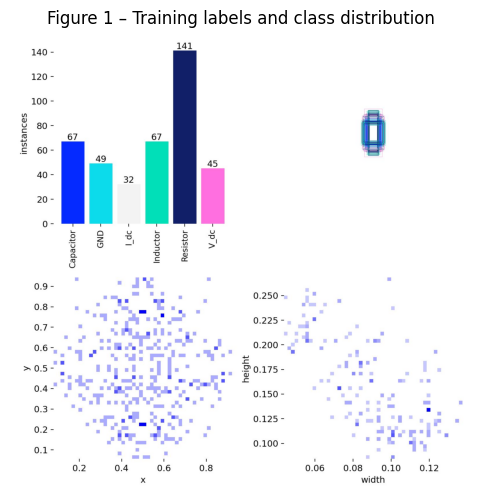

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/runs/detect/train/labels.jpg")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Figure 1 – Training labels and class distribution")
plt.show()

**Figure 1:**

* shows the distribution of bounding boxes and classes in
the training set for the six circuit components (Resistor, Capacitor, Inductor, GND, V_dc).
* This confirms that the labels are correctly parsed and that each component appears with a reasonable frequency for training.

In [6]:
#Load a pretrained YOLOv8 model (nano model)
model = YOLO("yolov8n.pt")

#Train on your dataset
results = model.train(
    data=DATA_YAML,   # path to data.yaml
    epochs=100,       # how many epochs to train the model through
    imgsz=640,        # image size
    batch=16,         # how many batches per epoch during training
)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Circuit-Diagram-CNN/Circuit Component Detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

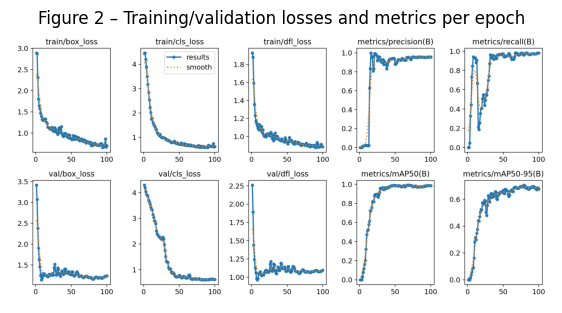

In [10]:
train_results_path = "/content/runs/detect/train/results.png"
img = Image.open(train_results_path)
plt.figure(figsize=(7, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Figure 2 – Training/validation losses and metrics per epoch")
plt.show()

**Figure 2:**

* Shows the evolution of training and validation losses and metrics (box loss, classification loss, objectness loss, mAP) over 100 epochs.
* The curves stabilize without diverging, which indicates that the model converged without clear overfitting on this dataset.

In [8]:
#Test the model on test circuit diagram images to check symbol detection performance
model = YOLO("runs/detect/train/weights/best.pt")

test_metrics = model.val(
    data=DATA_YAML,
    split="test"
    )

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.0±0.0 MB/s, size: 16.2 KB)
val: Scanning /content/drive/MyDrive/Circuit-Diagram-CNN/Circuit Component Detection/test/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5/5 8.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 5.3it/s 0.2s
                   all          5         32      0.973      0.917      0.988      0.731
             Capacitor          5          7      0.992          1      0.995      0.728
                   GND          4          4       0.99          1      0.995      0.646
              Inductor          5          5      0.922        0.8      0.962      0.674
              Resistor          5          9      0.963          1      0.995      0.742
          

**What these metrics mean:**

The key lines are...

```
# Class     Images  Instances      Box(P)      R      mAP50  mAP50-95
# all            7         51      0.953    0.96     0.976     0.7
```


**Interpreting the data:**

* Overall precision ≈ 0.973 (97% of detections are correct.)

* Overall recall ≈ 0.917 (The model finds ~91% of the components.)

* mAP@0.5 ≈ 0.988 (Very good object detection performance at IoU ≥ 0.5.)

* mAP@0.5–0.95 ≈ 0.731 (This is the stricter metric; 0.7+ on a tiny dataset is solid.)

**Per-class evaluations:**

* Capacitor / GND (Ground) / V_dc (Voltage source) look very strong.

* Inductor is the “weakest” class: recall 0.922, mAP50 0.84, mAP50-95 0.67, but is still decent. (If something were to fail, it will probably be inductors)

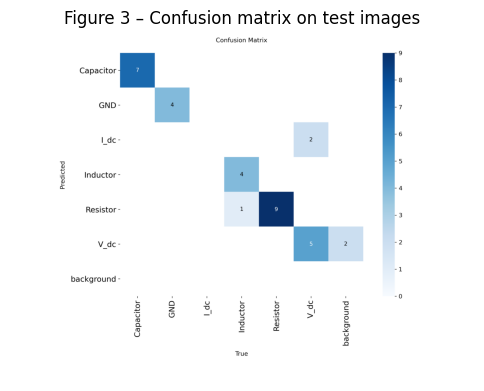

In [15]:
#Print confusion matrix output for testing

test_run_dir = "/content/runs/detect/val2"  # adjust to your actual test run dir
cm_path_test = f"{test_run_dir}/confusion_matrix.png"

img = Image.open(cm_path_test)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Figure 3 – Confusion matrix on test images")
plt.show()

**Figure 3**
* Shows the confusion matrix on the held-out test set of full hand-drawn circuit diagrams.
* The model correctly detects most components, with only a small number of errors. This matches the quantitative metrics (mAP50 ≈ 0.95, mAP50–95 ≈ 0.71).

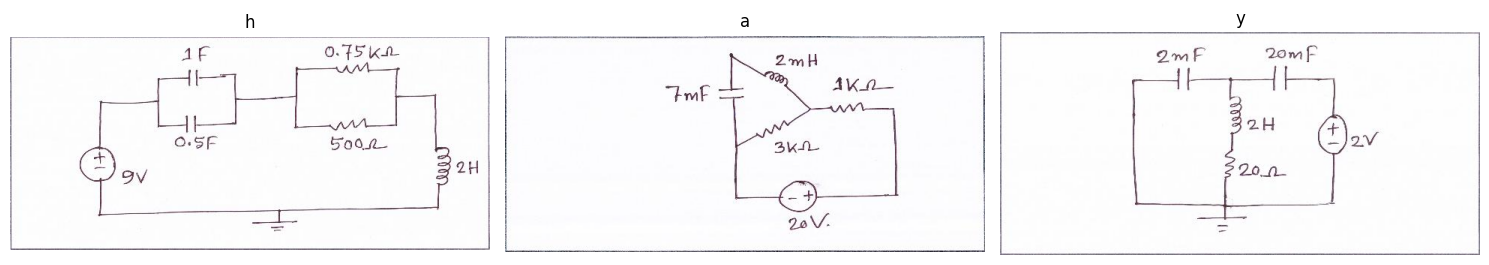

In [36]:
#Show some sample test images before the model makes a prediction on it

import os
import random
import cv2
import matplotlib.pyplot as plt

test_img_dir = "/content/drive/MyDrive/Circuit-Diagram-CNN/Circuit Component Detection/test/images"

test_images = [f for f in os.listdir(test_img_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
sample_test_images = random.sample(test_images, k=min(3, len(test_images)))

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(sample_test_images):
    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(sample_test_images), i + 1)
    plt.imshow(img)
    plt.title(f"{img_name [i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


0: 640x640 2 Capacitors, 1 GND, 1 Inductor, 2 Resistors, 1 V_dc, 5.7ms
1: 640x640 1 Capacitor, 3 Resistors, 1 V_dc, 5.7ms
2: 640x640 2 Capacitors, 1 GND, 1 Inductor, 1 Resistor, 1 V_dc, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


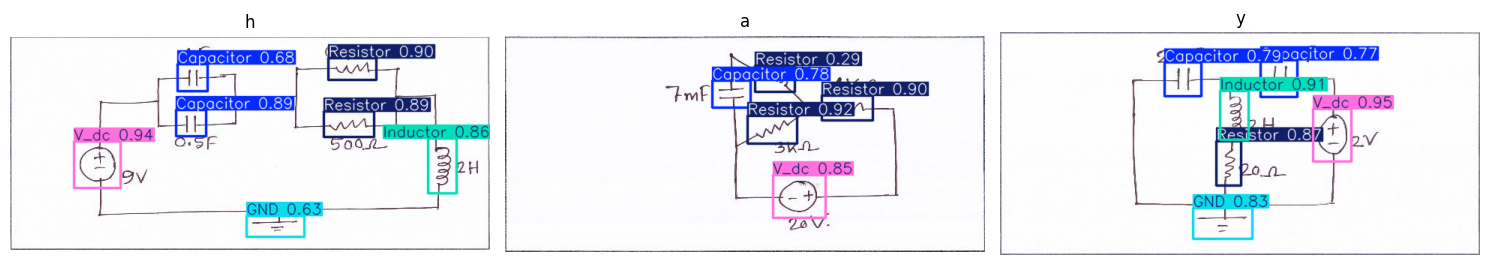

In [37]:
#Show the predcitions on the same images

# Load your trained model
model = YOLO("runs/detect/train/weights/best.pt")

# Use the same sample_test_images to compare "before vs after"
test_paths = [os.path.join(test_img_dir, name) for name in sample_test_images]

results = model.predict(source=test_paths, conf=0.25, save=False)
plt.figure(figsize=(15, 5))
for i, r in enumerate(results):
    # r.plot() returns an annotated image (numpy array)
    im = r.plot()  # BGR
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(results), i + 1)
    plt.imshow(im)
    plt.title(f"{img_name [i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()